# Task description
- Classify the speakers of given features.
- Main goal: Learn how to use transformer.
- Baselines:
  - Easy: Run sample code and know how to use transformer.
  - Medium: Know how to adjust parameters of transformer.
  - Strong: Construct [conformer](https://arxiv.org/abs/2005.08100) which is a variety of transformer. 
  - Boss: Implement [Self-Attention Pooling](https://arxiv.org/pdf/2008.01077v1.pdf) & [Additive Margin Softmax](https://arxiv.org/pdf/1801.05599.pdf) to further boost the performance.

- Other links
  - Kaggle: [link](https://www.kaggle.com/t/ac77388c90204a4c8daebeddd40ff916)
  - Slide: [link](https://docs.google.com/presentation/d/1HLAj7UUIjZOycDe7DaVLSwJfXVd3bXPOyzSb6Zk3hYU/edit?usp=sharing)
  - Data: [link](https://drive.google.com/drive/folders/1vI1kuLB-q1VilIftiwnPOCAeOOFfBZge?usp=sharing)

# Download dataset
- Data is [here](https://drive.google.com/drive/folders/1vI1kuLB-q1VilIftiwnPOCAeOOFfBZge?usp=sharing)

## ref
* https://github.com/Joshuaoneheart/ML2022_all_A_plus
* https://zhuanlan.zhihu.com/p/439212197
* https://github.com/pai4451/ML2021/tree/main/hw4
* https://blog.csdn.net/YI_SHU_JIA/article/details/124423639
* https://blog.csdn.net/loco_monkey/article/details/125635953

## 前置作業

In [ ]:
# # No use in kaggle 
# !wget https://github.com/MachineLearningHW/ML_HW4_Dataset/releases/latest/download/Dataset.tar.gz.partaa
# !wget https://github.com/MachineLearningHW/ML_HW4_Dataset/releases/latest/download/Dataset.tar.gz.partab
# !wget https://github.com/MachineLearningHW/ML_HW4_Dataset/releases/latest/download/Dataset.tar.gz.partac
# !wget https://github.com/MachineLearningHW/ML_HW4_Dataset/releases/latest/download/Dataset.tar.gz.partad

# !cat Dataset.tar.gz.part* > Dataset.tar.gz

# # unzip the file
# !tar zxvf Dataset.tar.gz

In [ ]:
!nvidia-smi

Mon Jul 25 05:41:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install git+https://github.com/sooftware/conformer.git
!pip install torchinfo

  Cloning https://github.com/sooftware/conformer.git to /tmp/pip-req-build-6tim_lta
  Running command git clone --filter=blob:none -q https://github.com/sooftware/conformer.git /tmp/pip-req-build-6tim_lta
  Resolved https://github.com/sooftware/conformer.git to commit 034cb3a5dee78ea4df127824481acc2da98e31bd
  Preparing metadata (setup.py) ... done
  Created wheel for conformer: filename=conformer-latest-py3-none-any.whl size=18342 sha256=fa324690ec914905d3f18e0f9ccd78f009335ebc8f3366a932fc817186ba6f9f
  Stored in directory: /tmp/pip-ephem-wheel-cache-wxdvm3_2/wheels/58/e3/8f/c80015975bb214b50aca0fcf6449d6f55154176de96c0a3046
Failed to build conformer
    Running setup.py install for conformer ... done
  DEPRECATION: conformer was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https://github.com/pypa/pip/issues/8368


In [ ]:
import numpy as np
import math
import os
import json
import csv
import random
from pathlib import Path
from collections import OrderedDict

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Optimizer, Adam, AdamW
from torch.optim.lr_scheduler import LambdaLR

from conformer import Conformer
from conformer.encoder import ConformerBlock
from torchinfo import summary

from tqdm.auto import tqdm

### Fix Random Seed

In [ ]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(3)

## Data

### Dataset
- Original dataset is [Voxceleb2](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox2.html).
- The [license](https://creativecommons.org/licenses/by/4.0/) and [complete version](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/files/license.txt) of Voxceleb2.
- We randomly select 600 speakers from Voxceleb2.
- Then preprocess the raw waveforms into mel-spectrograms.

- Args:
  - data_dir: The path to the data directory.
  - metadata_path: The path to the metadata.
  - segment_len: The length of audio segment for training. 
- The architecture of data directory \\
  - data directory \\
  |---- metadata.json \\
  |---- testdata.json \\
  |---- mapping.json \\
  |---- uttr-{random string}.pt \\

- The information in metadata
  - "n_mels": The dimention of mel-spectrogram.
  - "speakers": A dictionary. 
    - Key: speaker ids.
    - value: "feature_path" and "mel_len"


For efficiency, we segment the mel-spectrograms into segments in the traing step.

In [ ]:
# higher makes better because the lengh of test data is not fixed
segment_len_min = 128
segment_len = 138

In [ ]:
class myDataset(Dataset):
    def __init__(self, data_dir, segment_len, transforms=None):
        self.data_dir = data_dir
        self.segment_len = segment_len
        self.tf = transforms
    
        # Load the mapping from speaker neme to their corresponding id. 
        mapping_path = Path(data_dir) / "mapping.json"
        mapping = json.load(mapping_path.open())
        self.speaker2id = mapping["speaker2id"]
    
        # Load metadata of training data.
        metadata_path = Path(data_dir) / "metadata.json"
        metadata = json.load(open(metadata_path))["speakers"]
    
        # Get the total number of speaker.
        self.speaker_num = len(metadata.keys())
        self.data = []
        for speaker in metadata.keys():
            for utterances in metadata[speaker]:
                self.data.append([utterances["feature_path"], self.speaker2id[speaker]])
 
    def __len__(self):
            return len(self.data)
 
    def __getitem__(self, index):
        feat_path, speaker = self.data[index]
        # Load preprocessed mel-spectrogram.
        mel = torch.load(os.path.join(self.data_dir, feat_path))
        
        self.segment_len = random.randint(segment_len_min, segment_len)
        # Segmemt mel-spectrogram into "segment_len" frames.
        if len(mel) > self.segment_len:
            # Randomly get the starting point of the segment.
            start = random.randint(0, len(mel) - self.segment_len)
            # Get a segment with "segment_len" frames.
            mel = torch.FloatTensor(mel[start:start+self.segment_len])
        else:
            mel = torch.FloatTensor(mel)
        
        if self.tf:                                     # (length, features)
            mel = mel.permute(1,0)                      # (features, length)
            mel = self.tf(mel.unsqueeze(0)).squeeze(0)  # (1, features, length) => (features, length)
            mel = mel.permute(1,0)                      # (length, features)
        
        # Turn the speaker id into long for computing loss later.
        speaker = torch.FloatTensor([speaker]).long()
        return mel, speaker
 
    def get_speaker_number(self):
        return self.speaker_num

### Dataloader
- Split dataset into training dataset(90%) and validation dataset(10%).
- Create dataloader to iterate the data.

In [ ]:
def collate_batch(batch):
    # Process features within a batch.
    """Collate a batch of data."""
    mel, speaker = zip(*batch)
    # Because we train the model batch by batch, we need to pad the features in the same batch to make their lengths the same.
    mel = pad_sequence(mel, batch_first=True, padding_value=-20)    # pad log 10^(-20) which is very small value.
    # mel: (batch size, length, 40)
    return mel, torch.FloatTensor(speaker).long()


def get_dataloader(data_dir, batch_size, n_workers):
    """Generate dataloader"""
    dataset = myDataset(data_dir, segment_len=segment_len)
    speaker_num = dataset.get_speaker_number()
    # Split dataset into training dataset and validation dataset
    trainlen = int(0.9 * len(dataset))
    lengths = [trainlen, len(dataset) - trainlen]
    trainset, validset = random_split(dataset, lengths)
    print("train set", len(trainset))
    print("valid set", len(validset))

    train_loader = DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=n_workers,
        pin_memory=True,
        collate_fn=collate_batch,
    )
    valid_loader = DataLoader(
        validset,
        batch_size=batch_size,
        num_workers=n_workers,
        drop_last=True,
        pin_memory=True,
        collate_fn=collate_batch,
    )

    return train_loader, valid_loader, speaker_num

In [ ]:
# Transforms
import torchaudio

# transforms = None
transforms = torch.nn.Sequential(
    torchaudio.transforms.FrequencyMasking(freq_mask_param=40//3),
    torchaudio.transforms.TimeMasking(time_mask_param=segment_len_min//3),
)

data_dir = "../input/ml2022spring-hw4/Dataset"

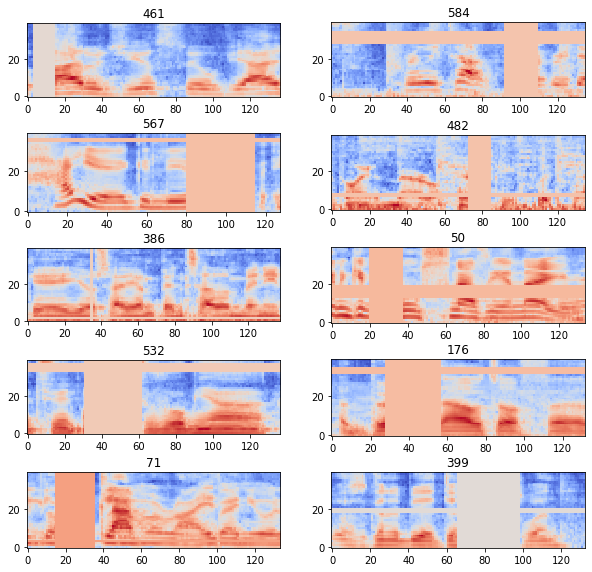

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

dataset = myDataset(data_dir, segment_len=segment_len, transforms=transforms)
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))
for ax_col in axs:
    for ax in ax_col:
        idx = random.randint(0, len(dataset))
        mfcc_data = dataset[idx][0].permute(1,0)
        ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
        ax.set_title(f'{dataset[idx][1].item()}')

plt.show()
del dataset

## PositionalEncoding

In [ ]:
# https://towardsdatascience.com/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
import math

class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp((-math.log(10000.0)) * torch.arange(0, dim_model, 2).float() / dim_model) # 1/10000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/10000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/10000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        """
        Args:
            token_embedding: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

## Self-attention pooling
* https://arxiv.org/abs/2008.01077
* https://gist.github.com/pohanchi/c77f6dbfbcbc21c5215acde4f62e4362
$$ C = Softmax(W_c H^T)H $$
$$ H = \left [h_1, h_2, \cdots  , h_T  \right ]^{Tr} \in  \mathbb{R}^{T \times d_m}$$
$$ W_c \in \mathbb{R}^{d_m} $$

In [ ]:
class SelfAttentionPooling(nn.Module):
    """
    Implementation of SelfAttentionPooling 
    Original Paper: Self-Attention Encoding and Pooling for Speaker Recognition
    https://arxiv.org/pdf/2008.01077v1.pdf
    """
    def __init__(self, dim):
        super().__init__()
        self.Q = nn.Linear(dim, 1)
        
    def forward(self, KV):
        """
        input:
            KV : size (N, T, F)
            N: batch size, T: sequence length, F: Feature dimension
        
        attention_weight:
            attention : size (N, 1, T)
        
        return:
            out: size (N, F)
        """
#         attention = F.softmax(self.Q(KV), dim=1)   # (N, T, 1)
#         attention = attention.permute(0, 2, 1)     # (N, 1, T)
#         out = torch.bmm(attention, KV)             # (N, 1, F)
#         out = out.squeeze(dim=1)                   # (N, F)

        attention = F.softmax(self.Q(KV), dim=1)   # (N, T, 1)
        out = attention * KV                       # (N, T, F)
        out = torch.sum(out, dim=1)                # (N, F)

        return out

## Model
- TransformerEncoderLayer:
  - Base transformer encoder layer in [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
  - Parameters:
    - d_model: the number of expected features of the input (required).

    - nhead: the number of heads of the multiheadattention models (required).

    - dim_feedforward: the dimension of the feedforward network model (default=2048).

    - dropout: the dropout value (default=0.1).

    - activation: the activation function of intermediate layer, relu or gelu (default=relu).

- TransformerEncoder:
  - TransformerEncoder is a stack of N transformer encoder layers
  - Parameters:
    - encoder_layer: an instance of the TransformerEncoderLayer() class (required).

    - num_layers: the number of sub-encoder-layers in the encoder (required).

    - norm: the layer normalization component (optional).

In [ ]:
class Classifier(nn.Module):
    def __init__(self, config, d_model=80, dim_feedforward=256, nhead=2, n_spks=600, dropout=0.1, num_layers=4):
        super().__init__()
    
        # Project the dimension of features from that of input into d_model.
        self.prenet = nn.Linear(40, d_model)
        
        self.positional_encoder = PositionalEncoding(
            dim_model=d_model, dropout_p=dropout, max_len=5000
        )
        # TODO:
        #   Change Transformer to Conformer.
        #   https://arxiv.org/abs/2005.08100
#         self.encoder_layer = nn.TransformerEncoderLayer(
#             d_model=d_model, dim_feedforward=dim_feedforward, nhead=nhead, dropout=dropout, batch_first=True,
#         )
#         self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.encoder = nn.Sequential(*[ConformerBlock(**config) for _ in range(num_layers)])
        
        self.self_attention_pooling = SelfAttentionPooling(d_model)
        
        # Project the the dimension of features from d_model into speaker nums.
        self.pred_layer = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Linear(d_model, n_spks),
        )

    def forward(self, mels):
        """
        args:
            mels: (batch size, length, 40)
        return:
            out: (batch size, n_spks)
        """
        out = self.prenet(mels)                   # (batch, length, d_model)
#         conformer build-in positional_encoder
#         out = out.permute(1,0,2)           # (length, batch, d_model)
#         out = self.positional_encoder(out) # (length, batch, d_model)
#         out = out.permute(1,0,2)           # (batch, length, d_model)
        out = self.encoder(out)                   # (batch, length, d_model)
        # mean pooling
#         stats = out.mean(dim=1)            # (batch, d_model)
        stats = self.self_attention_pooling(out)  # (batch, d_model)
    
        out = self.pred_layer(stats)              # (batch, n_spks)
        
        return out

In [ ]:
class Classifier_Conformer(nn.Module):
    def __init__(self, config):
        super().__init__()
    
        self.encoder = Conformer(**config)        
        self.self_attention_pooling = SelfAttentionPooling(config["num_classes"])


    def forward(self, mels):
        """
        args:
            mels: (batch size, length, 40)
        return:
            out: (batch size, n_spks)
        """
        out, _ = self.encoder(mels, mels.shape[1])     # (batch, length, d_model)
        # mean pooling
#         out = out.mean(dim=1)                          # (batch, n_spks)
        out = self.self_attention_pooling(out)         # (batch, n_spks)
        
        return out

## Train

### Hyperparameter

In [ ]:
model_parameters = {
        "num_classes": 600,
        "d_model": 1024,  # higher makes better
        "nhead": 32, 
        "num_layers": 1, # higher makes overfit
        "dropout": 0.2,
}

conformer_parameters = {
        "num_classes": model_parameters["num_classes"],
        "input_dim": 40,
        "encoder_dim": model_parameters["d_model"],
        "num_encoder_layers": model_parameters["num_layers"],
        "num_attention_heads": model_parameters["nhead"],
        "feed_forward_expansion_factor": 4,
        "conv_expansion_factor": 2,
        "input_dropout_p": model_parameters["dropout"],
        "feed_forward_dropout_p": model_parameters["dropout"],
        "attention_dropout_p": model_parameters["dropout"],
        "conv_dropout_p": model_parameters["dropout"],
        "conv_kernel_size": 31,
        "half_step_residual": True,
}

model_parameters["dim_feedforward"] = conformer_parameters["encoder_dim"] * conformer_parameters["feed_forward_expansion_factor"]

def parse_args():
    """arguments"""
    config = {
        "data_dir": data_dir,
        "save_path": "model.ckpt",
        "batch_size": 32,
        "n_workers": 2,
        "n_epochs": 100,
        "lr": 1e-4,
        "weight_decay": 0.0,
    }

    return config

In [ ]:
def get_model():
#     del conformer_parameters["num_classes"]
#     del conformer_parameters["input_dim"]
#     del conformer_parameters["num_encoder_layers"]
#     del conformer_parameters["input_dropout_p"]
#     return Classifier(conformer_parameters,
#                       n_spks=model_parameters["num_classes"], 
#                       d_model=model_parameters["d_model"],
#                       dim_feedforward=model_parameters["dim_feedforward"], 
#                       num_layers=model_parameters["num_layers"],
#                       nhead=model_parameters["nhead"],
#                       dropout=model_parameters["dropout"])
    
    return Classifier_Conformer(conformer_parameters)
    

In [ ]:
model = get_model()
model.eval()
batch_size = parse_args()["batch_size"]
train_loader, _, _ = get_dataloader(data_dir, batch_size, 2)
features = next(iter(train_loader))[0]
# assert batch size does not matter
assert (torch.argmax(model(features)[:batch_size//2], dim=1) == torch.argmax(model(features[:batch_size//2]), dim=1)).all()
del model, train_loader

train set 50999
valid set 5667


### Learning rate schedule
- For transformer architecture, the design of learning rate schedule is different from that of CNN.
- Previous works show that the warmup of learning rate is useful for training models with transformer architectures.
- The warmup schedule
  - Set learning rate to 0 in the beginning.
  - The learning rate increases linearly from 0 to initial learning rate during warmup period.

In [ ]:
def get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps: int,
    num_training_steps: int,
    num_cycles: float = 0.5,
    last_epoch: int = -1,
):
    """
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
    initial lr set in the optimizer.

    Args:
        optimizer (:class:`~torch.optim.Optimizer`):
        The optimizer for which to schedule the learning rate.
        num_warmup_steps (:obj:`int`):
        The number of steps for the warmup phase.
        num_training_steps (:obj:`int`):
        The total number of training steps.
        num_cycles (:obj:`float`, `optional`, defaults to 0.5):
        The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
        following a half-cosine).
        last_epoch (:obj:`int`, `optional`, defaults to -1):
        The index of the last epoch when resuming training.

    Return:
        :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """
    def lr_lambda(current_step, lowerbound=0.003):
        # Warmup
        if current_step < num_warmup_steps:
            return max(lowerbound, float(current_step) / float(max(1, num_warmup_steps)))
        # decadence
        progress = float(current_step - num_warmup_steps) / float(
            max(1, num_training_steps - num_warmup_steps)
        )
        return max(
            lowerbound, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
        )
    

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch)

train set 50999
valid set 5667


  0%|          | 0/159300 [00:00<?, ?it/s]

[3.0000000000000004e-07, 3.0000000000000004e-07, 3.0000000000000004e-07, 3.0000000000000004e-07, 3.0000000000000004e-07]
[3.0000000000000004e-07, 3.0000000000000004e-07, 3.0000000000000004e-07, 3.0000000000000004e-07, 3.0000000000000004e-07]


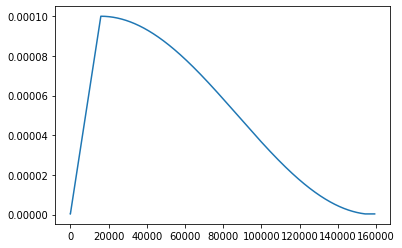

In [ ]:
import matplotlib.pyplot as plt

def show_plot(total, lr):
    optimizer = torch.optim.SGD(torch.nn.Linear(2, 1).parameters(), lr=lr)
    scheduler = get_cosine_schedule_with_warmup(optimizer, total//10, total)

    lrs = []

    for i in tqdm(range(total)):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()

    plt.plot(range(total), lrs)
    
    print(lrs[:5])
    print(lrs[-5:])

train_loader, _, _ = get_dataloader(data_dir, parse_args()["batch_size"], 2)
total_steps = len(train_loader) * parse_args()["n_epochs"]
show_plot(total_steps, parse_args()["lr"])
del train_loader

### Model Function
- Model forward function.

In [ ]:
def model_fn(batch, model, criterion, device):
    """Forward a batch through the model."""

    mels, labels = batch
    mels = mels.to(device)
    labels = labels.to(device)

    outs = model(mels)

    loss = criterion(outs, labels)

    # Get the speaker id with highest probability.
    preds = outs.argmax(1)
    # Compute accuracy.
    accuracy = torch.mean((preds == labels).float())

    return loss, accuracy

### Validate
- Calculate accuracy of the validation set.

In [ ]:
def valid(dataloader, model, criterion, device): 
    """Validate on validation set."""

    running_loss = 0.0
    running_accuracy = 0.0
    
    for batch in dataloader:
        model.eval()   
        loss, accuracy = model_fn(batch, model, criterion, device)
        running_loss += loss.item()
        running_accuracy += accuracy.item()

    return running_accuracy / len(dataloader)

### Main function

In [ ]:
# https://github.com/CoinCheung/pytorch-loss

class AMSoftmax(nn.Module):
    def __init__(self,
                 in_feats,
                 m=0.3,
                 s=15):
        super(AMSoftmax, self).__init__()
        self.m = m
        self.s = s
        self.in_feats = in_feats
        self.ce = nn.CrossEntropyLoss()

    def forward(self, x, lb):
        assert x.size()[0] == lb.size()[0]
        assert x.size()[1] == self.in_feats
        costh = x / torch.norm(x, p=2, dim=1, keepdim=True).clamp(min=1e-12)
        lb_view = lb.view(-1, 1)
        
        delt_costh = torch.zeros(costh.size())
        if lb_view.is_cuda: delt_costh = delt_costh.cuda()
        delt_costh = delt_costh.scatter_(1, lb_view, self.m)
        
        costh_m = costh - delt_costh
        costh_m_s = self.s * costh_m
        loss = self.ce(costh_m_s, lb)
        return loss

In [ ]:
model = get_model()
batch_size = parse_args()["batch_size"]
print(summary(
    model, 
    input_size=(batch_size, segment_len, 40), 
    col_names=("input_size", "output_size", "kernel_size", "num_params")
))
del model

Layer (type:depth-idx)                                                      Input Shape               Output Shape              Kernel Shape              Param #
Classifier_Conformer                                                        [32, 138, 40]             [32, 600]                 --                        --
├─Conformer: 1-1                                                            [32, 138, 40]             [32, 33, 600]             --                        --
│    └─ConformerEncoder: 2-1                                                [32, 138, 40]             [32, 33, 512]             --                        --
│    │    └─Conv2dSubampling: 3-1                                           [32, 138, 40]             [32, 33, 4608]            --                        2,364,928
│    │    └─Sequential: 3-2                                                 [32, 33, 4608]            [32, 33, 512]             --                        2,359,808
│    │    └─ModuleList: 3-3            

In [ ]:
def main(
    data_dir,
    save_path,
    batch_size,
    n_workers,
    n_epochs,
    lr,
    weight_decay ,
):
    """Main function."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info]: Use {device} now!")

    train_loader, valid_loader, speaker_num = get_dataloader(data_dir, batch_size, n_workers)
    print(f"[Info]: Finish loading data!",flush = True)

    model = get_model().to(device)
#     model.load_state_dict(torch.load("../input/hw04tmp/model.ckpt", map_location=device))
    
    criterion = AMSoftmax(speaker_num, m=0.5, s=30)
    # criterion = nn.CrossEntropyLoss()
#     optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    total_steps = len(train_loader) * parse_args()["n_epochs"]
    scheduler = get_cosine_schedule_with_warmup(optimizer, total_steps//10, total_steps)
    print(f"[Info]: Finish creating model!", flush=True)
    
    best_accuracy = 0.0
    
    for epoch in tqdm(range(n_epochs)):
        train_loss = 0
        train_accuracy = 0
        
        for batch in train_loader:
            model.train()
            loss, accuracy = model_fn(batch, model, criterion, device)
            train_loss += loss.item()
            train_accuracy += accuracy.item()

            # Updata model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

        # Do validation
        
        valid_accuracy = valid(valid_loader, model, criterion, device)

        # keep the best model
        if valid_accuracy > best_accuracy:
            best_accuracy = valid_accuracy
            torch.save(model.state_dict(), save_path)
        
        print(f"{epoch + 1:03d}: train_loss:{train_loss/len(train_loader):.3f}, train_accuracy:{train_accuracy/len(train_loader):.3f}, valid_accuracy:{valid_accuracy:.3f}, best_accuracy:{best_accuracy:.3f}")


    return best_accuracy


if __name__ == "__main__":
    best_accuracy = main(**parse_args())

[Info]: Use cuda now!
train set 50999
valid set 5667
[Info]: Finish loading data!
[Info]: Finish creating model!


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1593 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Inference

### Dataset of inference

In [ ]:
class InferenceDataset(Dataset):
    def __init__(self, data_dir):
        testdata_path = Path(data_dir) / "testdata.json"
        metadata = json.load(testdata_path.open())
        self.data_dir = data_dir
        self.data = metadata["utterances"]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        utterance = self.data[index]
        feat_path = utterance["feature_path"]
        mel = torch.load(os.path.join(self.data_dir, feat_path))

        return feat_path, mel


def inference_collate_batch(batch):
    """Collate a batch of data."""
    feat_paths, mels = zip(*batch)

    return feat_paths, torch.stack(mels)

### Main funcrion of Inference

In [ ]:
# best_accuracy=0.9310

In [ ]:
def parse_args():
    """arguments"""
    config = {
        "data_dir": "../input/ml2022spring-hw4/Dataset",
        "model_path": "model.ckpt",
        "output_path": f"./output_{best_accuracy:.4f}.csv",
    }

    return config

In [ ]:
def main(
    data_dir,
    model_path,
    output_path,
):
    """Main function."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info]: Use {device} now!")

    mapping_path = Path(data_dir) / "mapping.json"
    mapping = json.load(mapping_path.open())

    dataset = InferenceDataset(data_dir)
    dataloader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=False,
        drop_last=False,
        num_workers=1,
        collate_fn=inference_collate_batch,
    )
    print(f"[Info]: Finish loading data!",flush = True)

    speaker_num = len(mapping["id2speaker"])
    model = get_model().to(device)

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"[Info]: Finish creating model!",flush = True)

    results = [["Id", "Category"]]
    for feat_paths, datas in tqdm(dataloader, position=0, leave=True):
        with torch.no_grad():            
#             outs = torch.zeros(1, 600).to(device)
#             if datas.shape[1] > segment_len:
#                 start = 0
#                 while start+10 < datas.shape[1]: # add 10 avoiding error
#                     mels = datas[:, start:start+segment_len]
#                     mels = mels.to(device)
#                     outs += model(mels)
#                     start = start + segment_len
#             else:
            mels = datas.to(device)
            outs = model(mels)
            
            preds = outs.argmax(1).cpu().numpy()
            for feat_path, pred in zip(feat_paths, preds):
                results.append([feat_path, mapping["id2speaker"][str(pred)]])

    with open(output_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(results)


if __name__ == "__main__":
    main(**parse_args())